In [4]:
# first check the wd
# this should be AIggregation folder

import os
os.getcwd()

#os.chdir("..")


'/home/tmueller/github/AIggregation'

In [8]:


#now import fiftyone
import fiftyone as fo
from fiftyone import ViewField as F



# Import annotated test image into fiftyone dataset type
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv5Dataset,
    yaml_path = "datasets/test_image/test.yaml"
)



# open test image instance to verify it loaded correctly
session = fo.launch_app(dataset)



 100% |█████████████████████| 1/1 [85.6ms elapsed, 0s remaining, 11.9 samples/s] 


Performing prediction on 54 slices.
Detections predicted without slicing: 56
Detections predicted with slicing: 138



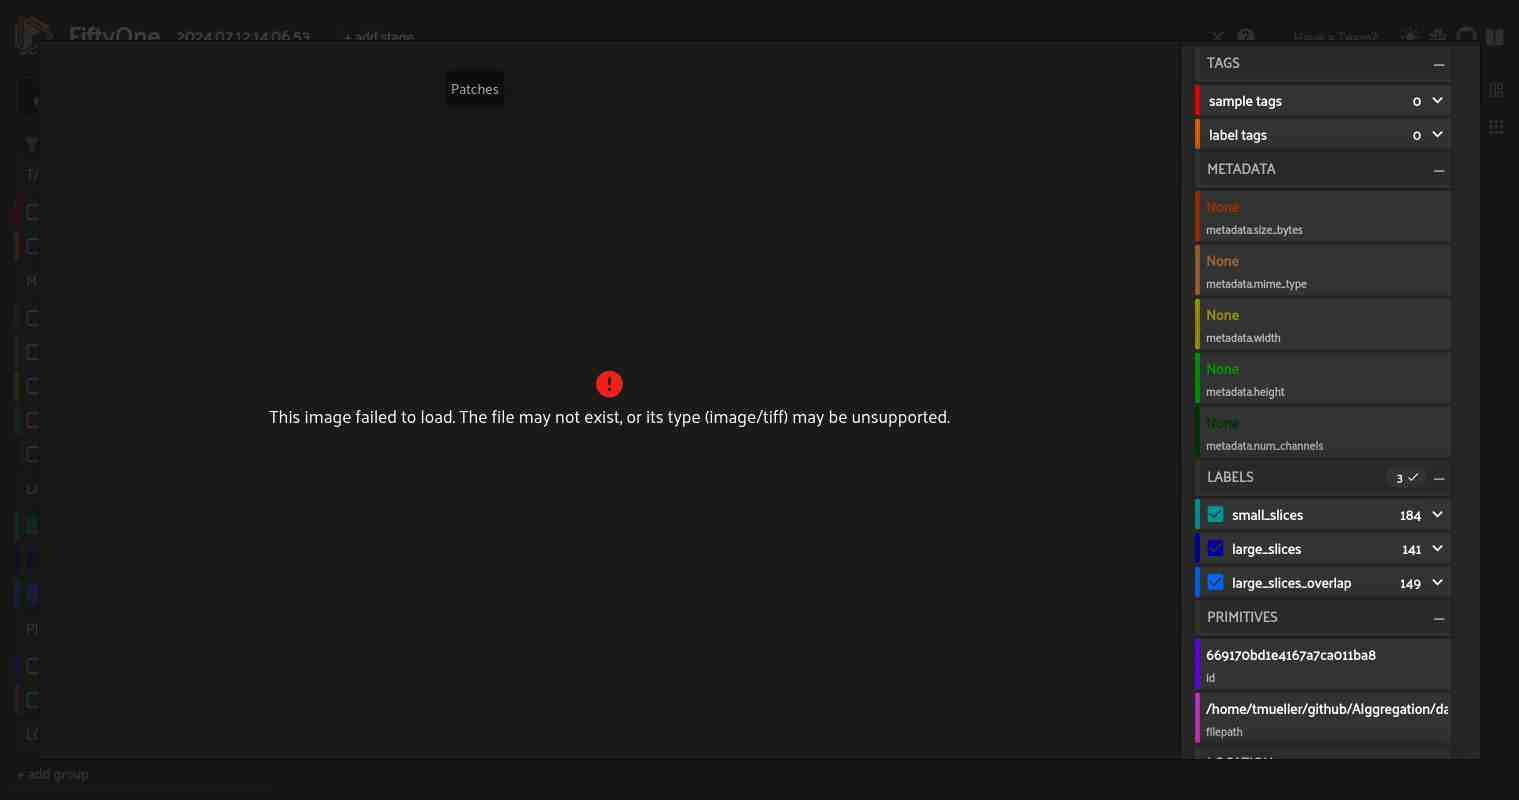

In [68]:
# import required sahi functions
from sahi import AutoDetectionModel
from sahi.predict import get_prediction, get_sliced_prediction, predict

os.getcwd()


# specify AI detection model
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov5',
    model_path='AIggregation_yolov5m/weights/best.pt', #specify path to trained model
    confidence_threshold=0.25,
    device="cpu", # or 'cuda:0'
)


# do a simple yolo prediction without slicing
# only on the first image in the dataset
result = get_prediction(dataset.first().filepath, detection_model)


# now do sliced prediction with sahi
sliced_result = get_sliced_prediction(
    dataset.first().filepath,
    detection_model,
    slice_height = 608,
    slice_width = 608,
    overlap_height_ratio = 0.1,
    overlap_width_ratio = 0.1
)


# compare number of detections with and without slicing just for fun
num_sliced_dets = len(sliced_result.to_fiftyone_detections())
num_orig_dets = len(result.to_fiftyone_detections())

print(f"Detections predicted without slicing: {num_orig_dets}")
print(f"Detections predicted with slicing: {num_sliced_dets}")



In [64]:



# Now to run and compare different slicing parameters
def predict_with_slicing(sample, label_field, **kwargs):
    result = get_sliced_prediction(
        sample.filepath, detection_model, verbose=0, **kwargs
    )
    sample[label_field] = fo.Detections(detections=result.to_fiftyone_detections())


#kwargs if you want to specify many arguments that are the same for all models
#kwargs = {"overlap_height_ratio": 0.2, "overlap_width_ratio": 0.2}

kwargs = {}


for sample in dataset.iter_samples(progress=True, autosave=True):
    predict_with_slicing(sample, label_field="small_slices", slice_height=304, slice_width=304, overlap_height_ratio = .2, overlap_width_ratio=.2, **kwargs)
    predict_with_slicing(sample, label_field="large_slices", slice_height=608, slice_width=608, overlap_height_ratio = .2, overlap_width_ratio=.2,  **kwargs)
    predict_with_slicing(sample, label_field="large_slices_overlap", slice_height=608, slice_width=608, overlap_height_ratio = .4, overlap_width_ratio=.4,  **kwargs)





# evaluate the different sahi predictions
large_slice_results = dataset.evaluate_detections("large_slices", gt_field="ground_truth", eval_key="eval_large_slices")
small_slice_results = dataset.evaluate_detections("small_slices", gt_field="ground_truth", eval_key="eval_small_slices")
overlap_slice_results = dataset.evaluate_detections("large_slices_overlap", gt_field="ground_truth", eval_key="eval_large_slices_overlap")

# print eval results
print("-" * 50)
print("Large slice results:")
large_slice_results.print_report()

print("-" * 50)
print("Large slice overlap results:")
overlap_slice_results.print_report()

print("-" * 50)
print("Small slice results:")
small_slice_results.print_report()



#bring up new session to see boxes
session.show()




 100% |█████████████████████| 1/1 [1.1m elapsed, 0s remaining, 0.0 samples/s] 


07/12/2024 14:08:44 - INFO - eta.core.utils -    100% |█████████████████████| 1/1 [1.1m elapsed, 0s remaining, 0.0 samples/s] 


ValueError: Dataset has no sample field 'ground_truth'


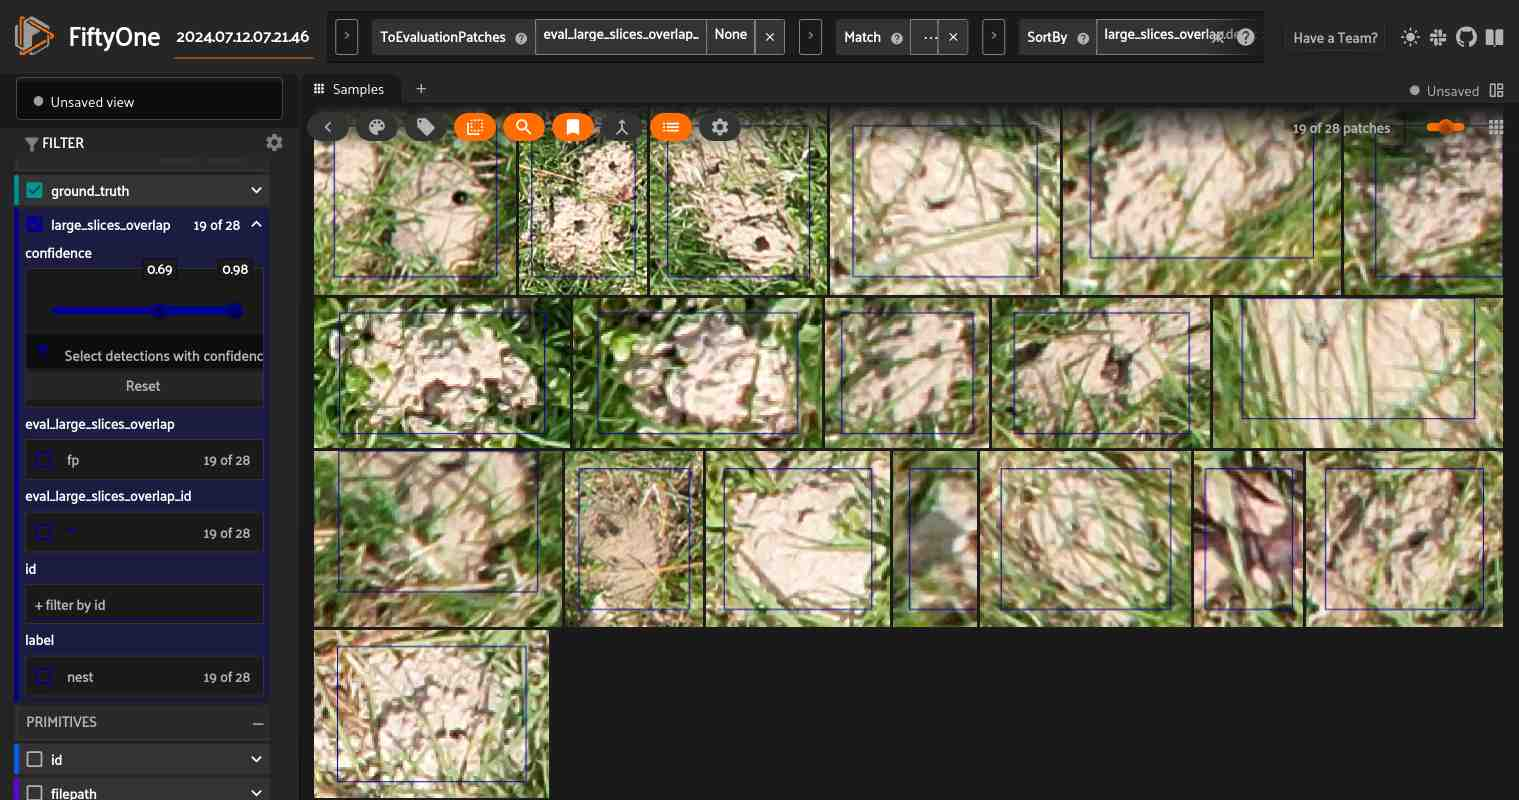

In [17]:
# now show images where sahi is labeling false positives
# check if ground_truth labels needs to be adjusted
# for instance in this very quickly annotated test image - AI is probably outperforming me to a degree...


high_conf_fp_view = dataset.to_evaluation_patches(eval_key="eval_large_slices_overlap").match(F("type")=="fp").sort_by("large_slices_overlap.detection.confidence")

session.view = high_conf_fp_view.view()

07/12/2024 15:10:04 - INFO - rasterio._filepath -   Object not found in virtual filesystem: filename=b'cb35e0c6-965c-4bf2-b06c-0fb70d4c7b4d/cb35e0c6-965c-4bf2-b06c-0fb70d4c7b4d.aux'
07/12/2024 15:10:04 - INFO - rasterio._filepath -   Object not found in virtual filesystem: filename=b'cb35e0c6-965c-4bf2-b06c-0fb70d4c7b4d/cb35e0c6-965c-4bf2-b06c-0fb70d4c7b4d.AUX'
07/12/2024 15:10:04 - INFO - rasterio._filepath -   Object not found in virtual filesystem: filename=b'cb35e0c6-965c-4bf2-b06c-0fb70d4c7b4d/cb35e0c6-965c-4bf2-b06c-0fb70d4c7b4d.aux'
07/12/2024 15:10:04 - INFO - rasterio._filepath -   Object not found in virtual filesystem: filename=b'cb35e0c6-965c-4bf2-b06c-0fb70d4c7b4d/cb35e0c6-965c-4bf2-b06c-0fb70d4c7b4d.AUX'


 100% |█████████████████████| 1/1 [26.4ms elapsed, 0s remaining, 43.1 samples/s] 


07/12/2024 15:10:04 - INFO - eta.core.utils -    100% |█████████████████████| 1/1 [26.4ms elapsed, 0s remaining, 43.1 samples/s] 


Name:        2024.07.12.15.10.04
Media type:  image
Num samples: 1
Persistent:  False
Tags:        []
Sample fields:
    id:       fiftyone.core.fields.ObjectIdField
    filepath: fiftyone.core.fields.StringField
    tags:     fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    location: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.GeoLocation)



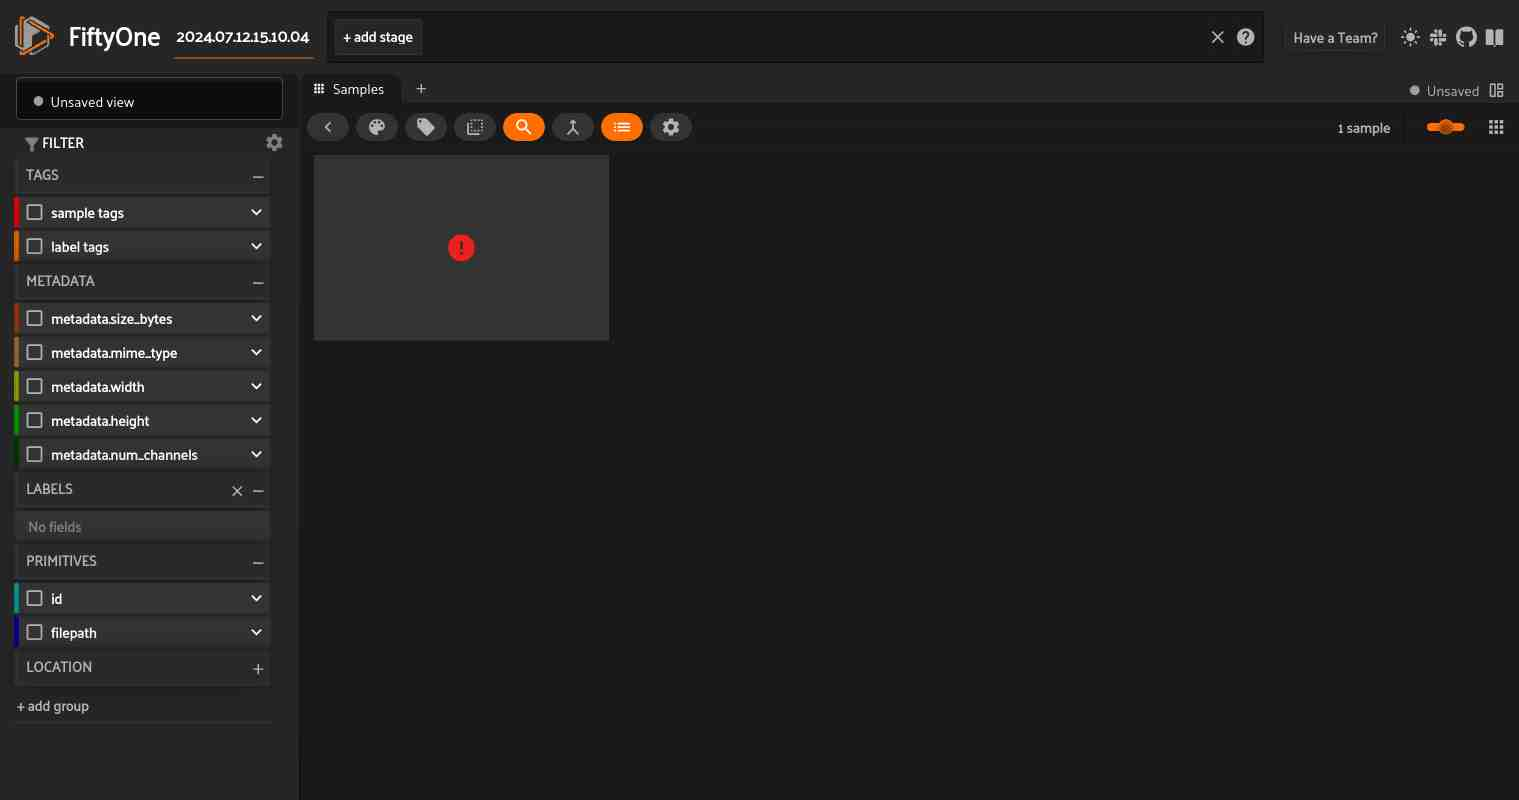

In [71]:

# in theory fifty one can work with geotiffs
# which would be handy... but i cant get it to open. Possibly because firefox or jupyter notebook wont support viewing tifs?



# to do geotiff you must pip install rasterio
import rasterio
import fiftyone as fo

data_dir = "datasets/drone_ortho/test"

image_path = "datasets/test.tif"

# Create the dataset
dataset_geo = fo.Dataset.from_dir(
    image_path=image_path,
    #dataset_dir= data_dir,
    dataset_type=fo.types.GeoTIFFDataset,
    label_field="location"
)

print(dataset_geo)

session = fo.launch_app(dataset_geo)


In [88]:
# tests for exporting predictions to yolo format



import fiftyone as fo

# Import annotated test image into fiftyone dataset type
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv5Dataset,
    yaml_path = "datasets/test_image/test.yaml"
)


export_dir = "datasets/export_test"
label_field = "ground_truth"  



dataset.export(
        export_dir=export_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field=label_field,
    )






 100% |█████████████████████| 1/1 [63.9ms elapsed, 0s remaining, 16.2 samples/s] 


07/12/2024 15:24:57 - INFO - eta.core.utils -    100% |█████████████████████| 1/1 [63.9ms elapsed, 0s remaining, 16.2 samples/s] 


Directory 'datasets/export_test' already exists; export will be merged with existing files


07/12/2024 15:24:57 - WARNING - fiftyone.core.collections -   Directory 'datasets/export_test' already exists; export will be merged with existing files


 100% |█████████████████████| 1/1 [63.8ms elapsed, 0s remaining, 15.7 samples/s] 


07/12/2024 15:24:57 - INFO - eta.core.utils -    100% |█████████████████████| 1/1 [63.8ms elapsed, 0s remaining, 15.7 samples/s] 
